<a href="https://colab.research.google.com/github/hsym-uec/myWeb_github/blob/main/Simmple_Stock.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# SoftBank Stock data from Stooq.com 
# reference https://seanmemo.com/234/
import mplfinance as mpf
import numpy as np
import matplotlib.pyplot as plt
import datetime
from dateutil.relativedelta import relativedelta
from pandas_datareader import data
start = '2022-04-01'
end = '2023-05-31'
#9984:ソフトバンク
#df = data.DataReader('9984.JP', 'stooq', start, end)
#7832:バンナム
df = data.DataReader('7832.JP', 'stooq', start, end)

In [3]:
df

,Open,High,Low,Close,Volume
Date,,,,,
2023-05-31,3300.00,3309.00,3252.00,3271.00,3.284100e+06
2023-05-30,3326.00,3326.00,3285.00,3320.00,1.132700e+06
2023-05-29,3333.00,3342.00,3305.00,3307.00,2.197500e+06
2023-05-26,3303.00,3303.00,3251.00,3263.00,1.515200e+06
2023-05-25,3293.00,3314.00,3272.00,3283.00,1.833200e+06
...,...,...,...,...,...
2022-04-07,9069.86,9227.40,9068.86,9176.55,5.489779e+05
2022-04-06,9106.75,9220.42,9066.87,9180.54,6.162713e+05
2022-04-05,9285.24,9315.15,9178.54,9245.35,4.842919e+05


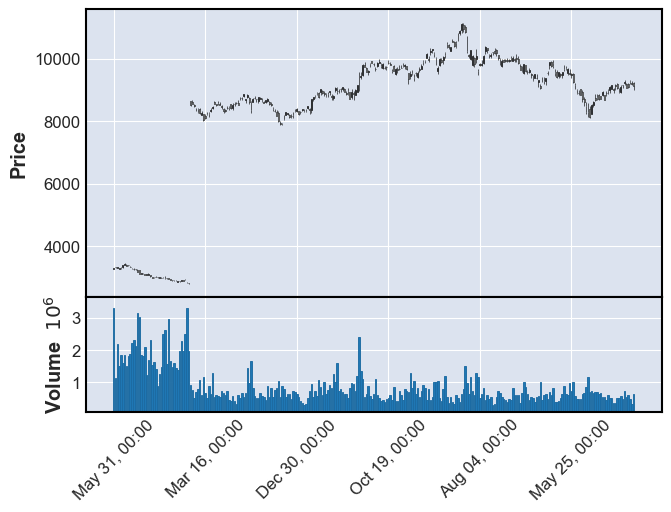

In [4]:
import mplfinance as mpf
mpf.plot(df, type='candle',volume=True)

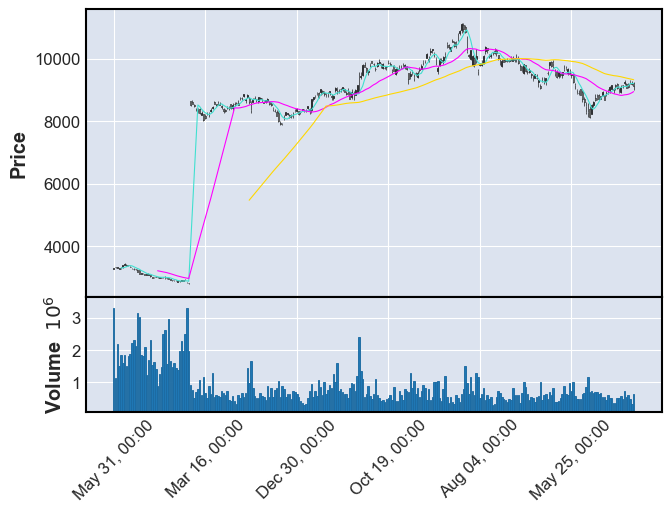

In [5]:
mpf.plot(df,type='candle',mav=(5,25,75),volume=True)

In [6]:
df['High'].max(), df['Low'].min()

(11157.8, 2787.0)

In [7]:
kwargs = dict(type = 'candle', volume = True, mav = (9,17,26), style = 'yahoo')

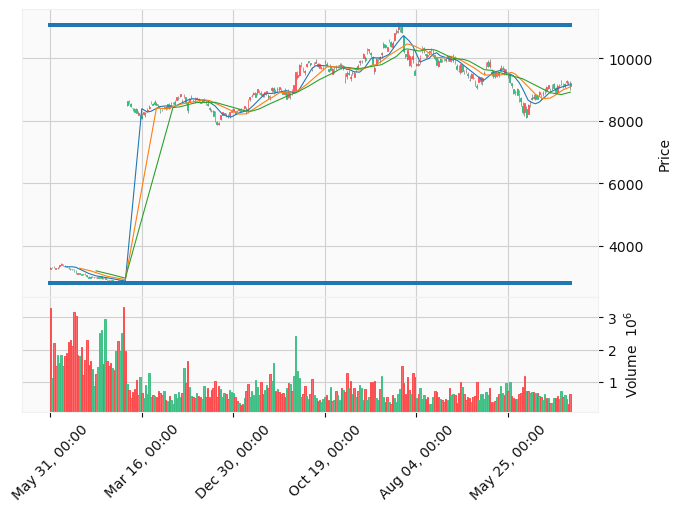

In [8]:
mpf.plot(df, **kwargs, hlines = [float(df['Close'].max()), float(df['Close'].min())])

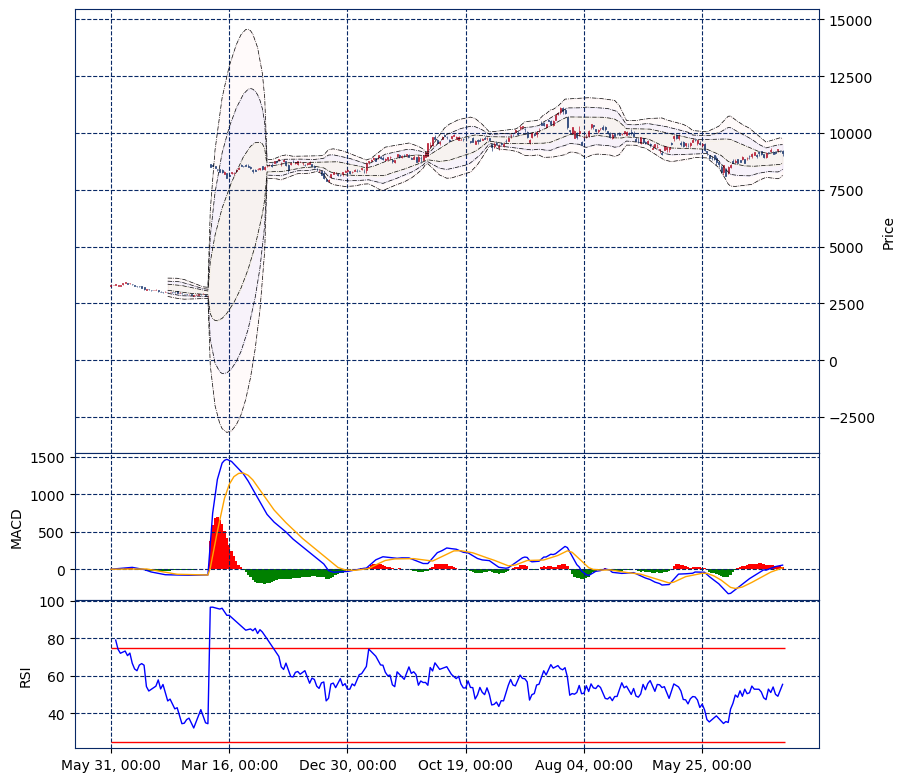

In [9]:
def bollingerband(c, period):
    bbma = c.rolling(window=period).mean() ## 平均
    bbstd = c.rolling(window=period).std() ## 標準偏差
    bbh1 = bbma + bbstd * 1
    bbl1 = bbma - bbstd * 1
    bbh2 = bbma + bbstd * 2
    bbl2 = bbma - bbstd * 2
    bbh3 = bbma + bbstd * 3
    bbl3 = bbma - bbstd * 3
    return bbh1, bbl1, bbh2, bbl2, bbh3, bbl3

def macd(c, n1, n2, ns):
    ema_short = c.ewm(span=n1,adjust=False).mean()
    ema_long = c.ewm(span=n2,adjust=False).mean()
    macd = ema_short - ema_long
    signal = macd.ewm(span=ns,adjust=False).mean()
    histogram = macd - signal
    histogramplus = histogram.where(histogram > 0, 0)
    histogramminus = histogram.where(histogram < 0, 0)
    return macd,signal,histogram,histogramplus,histogramminus

def rsi(c, period):
    diff = c.diff() #前日比
    up = diff.copy() #上昇
    down = diff.copy() #下落
    up = up.where(up > 0, np.nan) #上昇以外はnp.nan
    down = down.where(down < 0, np.nan) #下落以外はnp.nan
    #upma = up.rolling(window=period).mean() #平均
    #downma = down.abs().rolling(window=period).mean() #絶対値の平均
    upma = up.ewm(span=period,adjust=False).mean() #平均
    downma = down.abs().ewm(span=period,adjust=False).mean() #絶対値の平均
    rs = upma / downma
    rsi = 100 - (100 / (1.0 + rs))
    return rsi

c = df['Close']
# ボリンジャーバンド（移動平均25日線）
bbh1, bbl1, bbh2, bbl2, bbh3, bbl3 = bollingerband(c, 25)
# MACD（短期=12，長期=26，シグナル=9）
macd_, macdsignal, histogram, histogramplus, histogramminus = macd(c, 12, 26, 9)
# RSI（14日）
rsi_ = rsi(c, 14)

# 高さの比を 3:1:1 で GridSpec を用意する
fig = mpf.figure(figsize=(9.6, 9.6), style='starsandstripes')
gs = fig.add_gridspec(3, 1, hspace=0, wspace=0, height_ratios=(3,1,1))
(ax1,ax2,ax3) = gs.subplots(sharex='col')

# ボリンジャーバンドは axes No.1 に描く
bbargs = dict(ax=ax1, width=.5, linestyle='dashdot', color='black')
# MACD は axes No.2 に描く
macdargs = dict(ax=ax2, width=1, ylabel='MACD')
# RSI は axes No.3 に描く
rsiargs = dict(ax=ax3, width=1, ylabel='RSI')

ap = [
    mpf.make_addplot(bbh1, **bbargs),
    mpf.make_addplot(bbl1, **bbargs),
    mpf.make_addplot(bbh2, **bbargs),
    mpf.make_addplot(bbl2, **bbargs),
    mpf.make_addplot(bbh3, **bbargs),
    mpf.make_addplot(bbl3, **bbargs),
    mpf.make_addplot(macd_, **macdargs, color='blue'),
    mpf.make_addplot(macdsignal, **macdargs, color='orange'),
    mpf.make_addplot(histogramplus, **macdargs, color='red', type='bar'),
    mpf.make_addplot(histogramminus, **macdargs, color='green', type='bar'),
    mpf.make_addplot(rsi_, **rsiargs, color='blue')
]
# ボリンジャーバンド(axes=1)の間を塗りつぶす（色は適当）
ax1.fill_between(x=range(0, len(df.index)), y1=bbh3.values, y2=bbl3.values, alpha=0.02, color='red')
ax1.fill_between(x=range(0, len(df.index)), y1=bbh2.values, y2=bbl2.values, alpha=0.03, color='blue')
ax1.fill_between(x=range(0, len(df.index)), y1=bbh1.values, y2=bbl1.values, alpha=0.04, color='yellow')

# RSI(axes=3) の25%と75%に線を引く
ax3.hlines(xmin=0, xmax=len(df.index), y=25, linewidth=1, color='red')
ax3.hlines(xmin=0, xmax=len(df.index), y=75, linewidth=1, color='red')

mpf.plot(df, ax=ax1, addplot=ap, style='starsandstripes', type='candle', xrotation=30, ylabel='Price')
mpf.show()

ModuleNotFoundError: No module named 'pyti'